In [1]:
# SETUP yours
user_libs = "C:/Users/User/AppData/Local/R/cache/R/renv/library/functional-data-regression-mip-e3349204/R-4.3/x86_64-w64-mingw32"
.libPaths(c(user_libs,.libPaths()))



In [2]:
# run_simulation.R
# This script contains the function to run the simulation and returns all relevant outputs.

library(refund)
library(MASS)
library(fda)
library(here)

# Source the generic simulator script
source(here("src", "R", "generic_simulator", "simulate_main.R"))
source(here("src", "R", "generic_simulator", "utils","loader_utilities.R"))


# Define the function to run the simulation
run_simulation <- function(params) {
  # Ensure that the seed is set for reproducibility
  
  # Call the main analysis function with the parameters
  result <- do.call(generate_data, params[c("predictors", "observations", "measurements", "basis_functions", "intercept", "norder", "mu_funcs", "beta_funcs","time_domains", "cov_funcs", "seed","noise_snr","simulation_type")] )
    
  # Return the output list
  return(result)
}



simulation_name = "3_predictors"
simulation_settings_file = "default"
# Required inputs before running the simulation!!!
inputs  <- load_simulation_settings(simulation_name, simulation_settings_file)
inputs$measurements <- 500
inputs$observations <- 1000
inputs$basis_functions <- 6
time_domains_eval <- lapply(inputs$time_domains, function(domain) {
           seq(from = domain[[1]], to = domain[[2]], length.out = inputs$measurements)
       })
inputs$time_domains <- time_domains_eval
inputs$noise_snr <- c(100,100)
outputs <- run_simulation(inputs);



Warning message:
"il pacchetto 'refund' è stato creato con R versione 4.3.2"
Warning message:
"il pacchetto 'fda' è stato creato con R versione 4.3.2"
Caricamento del pacchetto richiesto: splines

Caricamento del pacchetto richiesto: fds

Warning message:
"il pacchetto 'fds' è stato creato con R versione 4.3.2"
Caricamento del pacchetto richiesto: rainbow

Warning message:
"il pacchetto 'rainbow' è stato creato con R versione 4.3.2"
Caricamento del pacchetto richiesto: pcaPP

Warning message:
"il pacchetto 'pcaPP' è stato creato con R versione 4.3.2"
Caricamento del pacchetto richiesto: RCurl

Warning message:
"il pacchetto 'RCurl' è stato creato con R versione 4.3.2"
Caricamento del pacchetto richiesto: deSolve

Warning message:
"il pacchetto 'deSolve' è stato creato con R versione 4.3.2"

Caricamento pacchetto: 'fda'


Il seguente oggetto è mascherato da 'package:graphics':

    matplot


Warning message:
"il pacchetto 'here' è stato creato con R versione 4.3.2"
Warning message in re

[1] 100 NaN NaN
[1] "predictors: 3"
[1] "observations: 1000"
[1] "measurements: 500"
[1] "basis_functions: 6"
[1] "intercept: 0"
[1] 100 100


In [9]:
require(splines)
require(grplasso)


grplFlinear <- function(Y, X, Tps, lambda, phi, dfs = 10,
adapt1 = NULL, adapt2 = NULL, ...){

	#### Observed functions x_{ij}(t) at possibly different support grids t
	## Y = nx1 vector of responses
	## X = list of matrices, each element corresponds to observations of one functional predictor.
	##		Thus, [[jj]] would provide the jj-th observed function with subjects as rows and the support grid as columns
	##		Note that each function (i.e. component of X) can have different support
	## Tps = list of vectors, each element is a suppport grid of the corresponding observed function.
	##		Thus, Tps[[jj]] would give the support grid of the jj-th observed function. This grid is
	##		assumed to be the same for all subjects ii, and equidistant
	## lambda = vector of penalty parameters
	## phi = penalty parameter for smoothing
	## dfs = dfs used for basis expansions of coefficient functions (can be a vector)


	nsub = length(Y) ## number of subjects
	nfunc = length(Tps) ## number of functions per subject



	#### We use bsplines as basis functions for the corrsponding beta functions
  if (length(dfs) == 1)
    dfs = rep(dfs, nfunc) ## vector of intended df of each spline basis
  if (length(dfs) != nfunc)
    stop("length of dfs does not match number of predictors")

	B <- Psi <- Omega <- K <- iR <- eK <- list()
	delt <- rep(NA, nfunc)


	for (jj in 1:nfunc){
		
    spj = diff(range(Tps[[jj]]))#/(dfs[jj]-2)
    bknj = c(min(Tps[[jj]]) - spj, max(Tps[[jj]]) + spj) ## boundary knots
		B[[jj]] = bs(Tps[[jj]], df=dfs[jj], Boundary.knots=bknj) ## basis spline set up
		delt[jj] = Tps[[jj]][2] - Tps[[jj]][1] ## differences in Tps

		Psi[[jj]] = delt[jj] * t(B[[jj]]) %*% B[[jj]] ## approximate norm of bsplines assuming dense design
    if (length(adapt1) == nfunc)
      Psi[[jj]] = adapt1[jj]*Psi[[jj]]

    dBj <- matrix(NA,nrow(B[[jj]]),ncol(B[[jj]]))
    for (k in 1:ncol(B[[jj]])) ## computation of second derivatives
      {
        iS <- interpSpline(Tps[[jj]],B[[jj]][,k])
        dBj[,k] <- predict(iS, Tps[[jj]], deriv = 2)$y
      }
    Omega[[jj]] = delt[jj] * t(dBj) %*% dBj ## approximate norm of 2nd deriv of bsplines assuming dense design
    if (length(adapt2) == nfunc)
      Omega[[jj]] = adapt2[jj]*Omega[[jj]]

		K[[jj]] = Psi[[jj]] + phi * Omega[[jj]] ## K matrix

    # Check eigenvalues
    eig_vals <- eigen(K[[jj]])$values
    if (any(eig_vals <= 0)) {
        cat("Matrix K[", jj, "] has non-positive eigenvalues.\n")
        # Diagonal loading for numerical stability
        K[[jj]] <- K[[jj]] + diag(abs(min(eig_vals)) + 1e-6, ncol(K[[jj]]))
    }


    eK[[jj]] <- eigen(K[[jj]])
    #iR[[jj]] <- t((1/sqrt(eK[[jj]]$values))*t(eK[[jj]]$vectors))
		iR[[jj]] = backsolve(chol(K[[jj]]), x = diag(ncol(K[[jj]])))  ## inverse of cholesky of K
	}


	## covariates for the linear model
	Z = 1
	for (jj in 1:nfunc)
    {
			tmp = delt[jj]*(X[[jj]]%*%B[[jj]])
			Z = cbind(Z, tmp%*%iR[[jj]])
		}


	## group lasso
	index = c(NA,rep(1:nfunc,dfs))
	grpl = grplasso(x = Z, y = Y, index = index, model = LinReg(), lambda = lambda,
  standardize = F, ...)


  ## output: intercept and fitted coefficient functions
  intercept = grpl$coef[1,]
  Coef <- list()
  index[1] = 0
  for (jj in 1:nfunc)
    {
      Coef[[jj]] <- B[[jj]]%*%iR[[jj]]%*%grpl$coef[index == jj,]
    }

  out = list("intercept" = intercept, "Coef" = Coef, "real_coef" = grpl$coef, "Z" = Z)
	return(out)
}


In [10]:

X = outputs$X
Y = outputs$Y

In [11]:
obseravation = dim(X)[1]    
predictors = dim(X)[2]
measurements = dim(X)[3]

fobs <- list()
for (j in 1:predictors) {
  fobs[[j]] <- matrix(0, obseravation, measurements)
  for (i in 1:obseravation) {
    fobs[[j]][i,] <- X[i,j,]
  }
}

In [12]:
tps <- list()
# for any time_domain, create a vector of time points from 1:measurements
tps <- inputs$time_domains


In [16]:
betas= grpl[[1]]$real_coef
to_matrix_form <-  function(predictor_coefficients, predictors, basis_functions) {
    # Create a matrix with 'basis_functions' elements per row
    # and the number of rows equal to the number of predictors from coeff_full
    coeff_matrix = matrix(0, nrow = predictors, ncol = basis_functions)

    for (i in 1:(predictors * basis_functions)) {
        # Calculate the row index as the ceiling of the division of 'i' by 'basis_functions'
        row_index = (i - 1) %/% basis_functions + 1
        # Calculate the column index as 'i' modulo 'basis_functions'; if modulo is 0, it means it's the last measurement
        col_index = ifelse(i %% basis_functions == 0, basis_functions, i %% basis_functions)
        # Assign the value of the coefficient to the matrix
        coeff_matrix[row_index, col_index] = predictor_coefficients[i]
}

  return(coeff_matrix)
}
beta_star = to_matrix_form(betas, 3, 6)

print(beta_star)

            [,1]         [,2]         [,3]         [,4]         [,5]
[1,]  0.14253599  0.864817707 -0.635809400 -0.546243884  1.296917172
[2,] -0.06327460  0.630694831  1.055856857 -1.107789383 -0.433774597
[3,] -0.05964922 -0.005347634  0.004450336  0.003363728  0.009072483
             [,6]
[1,]  0.064790843
[2,]  0.509147391
[3,] -0.009123044


In [14]:
print( outputs$B)

            [,1]      [,2]      [,3]      [,4]       [,5]       [,6]
[1,]  0.94212873 1.1817132 -1.101617 -1.101617  1.1817132 0.94212873
[2,] -0.02677813 0.8061591  1.610005 -1.610005 -0.8061591 0.02677813
[3,]  0.00000000 0.0000000  0.000000  0.000000  0.0000000 0.00000000


In [15]:
# fit using functional smooth group lasso

lambda <- c(0,0)
phi <- c(0)

grpl <- list()
for (i in 1:length(phi)) {
  grpl[[i]] <- grplFlinear(Y = Y, X = fobs, Tps = tps, lambda = lambda, phi = phi[i], dfs = inputs$basis_functions )
}



Lambda: 0  nr.var: 19 
Lambda: 0  nr.var: 19 


In [17]:
names(grpl)

NULL

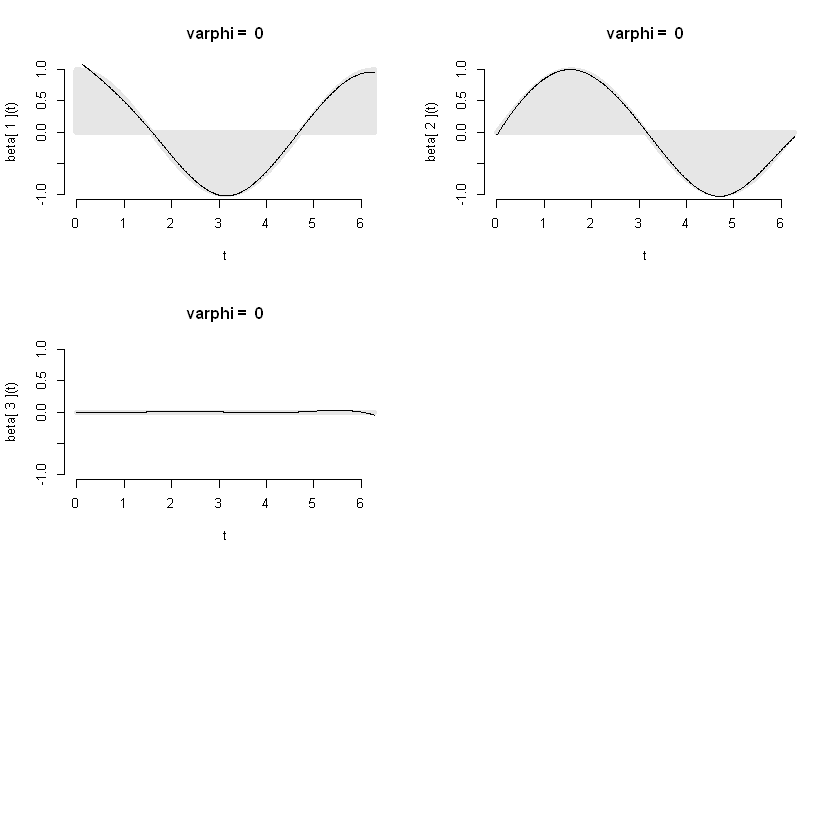

In [18]:
for (i in 1:length(phi)) {
  par(mfrow=c(3,2))  # Arrange the plots in a 3x2 grid
  for (j in 1:predictors) {
    plot(tps[[j]], beta_funcs[[j]](tps[[j]]), type="h",col=grey(0.9),lwd=5, xlab="t", ylab=paste("beta[", j, "](t)"), bty="n")
    for(wl in 1:length(lambda)) {
      lines(tps[[j]], grpl[[i]]$Coef[[j]][,wl],lty=wl)
    }
    title(paste("varphi = ", phi[i]))
  }
}

In [19]:
# fit using functional smooth group lasso
lambda <- 10^seq(5,-15,by=-1)
phi <- 10^seq(0,-4,by=-0.05)

grpl <- list()
for (i in 1:length(phi)) {
  grpl[[i]] <- grplFlinear(Y = Y, X = fobs, Tps = tps, lambda = lambda, phi = phi[i], dfs = inputs$basis_functions )
}



Setting update.every = length(lambda) + 1
Lambda: 1e+05  nr.var: 1 
Lambda: 10000  nr.var: 1 
Lambda: 1000  nr.var: 1 
Lambda: 100  nr.var: 13 
Lambda: 10  nr.var: 13 
Lambda: 1  nr.var: 19 
Lambda: 0.1  nr.var: 19 
Lambda: 0.01  nr.var: 19 
Lambda: 0.001  nr.var: 19 
Lambda: 1e-04  nr.var: 19 
Lambda: 1e-05  nr.var: 19 
Lambda: 1e-06  nr.var: 19 
Lambda: 1e-07  nr.var: 19 
Lambda: 1e-08  nr.var: 19 
Lambda: 1e-09  nr.var: 19 
Lambda: 1e-10  nr.var: 19 
Lambda: 1e-11  nr.var: 19 
Lambda: 1e-12  nr.var: 19 
Lambda: 1e-13  nr.var: 19 
Lambda: 1e-14  nr.var: 19 
Lambda: 1e-15  nr.var: 19 
Setting update.every = length(lambda) + 1
Lambda: 1e+05  nr.var: 1 
Lambda: 10000  nr.var: 1 
Lambda: 1000  nr.var: 1 
Lambda: 100  nr.var: 13 
Lambda: 10  nr.var: 13 
Lambda: 1  nr.var: 19 
Lambda: 0.1  nr.var: 19 
Lambda: 0.01  nr.var: 19 
Lambda: 0.001  nr.var: 19 
Lambda: 1e-04  nr.var: 19 
Lambda: 1e-05  nr.var: 19 
Lambda: 1e-06  nr.var: 19 
Lambda: 1e-07  nr.var: 19 
Lambda: 1e-08  nr.var: 19 
Lam

ERROR: Error in plot.window(...): valore 'ylim' non valido


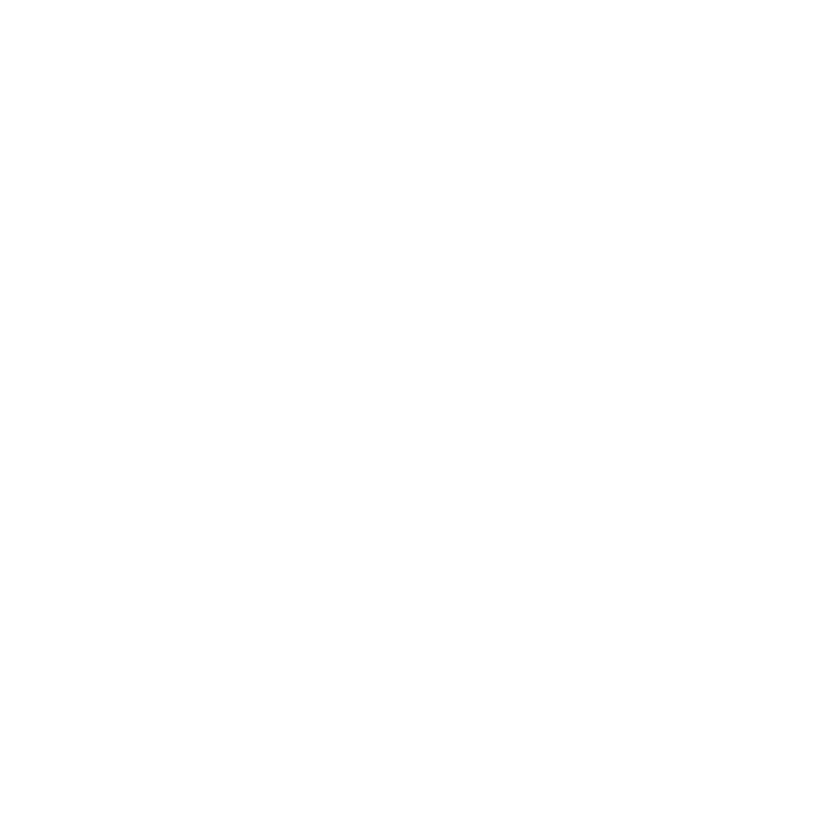

In [23]:
for (i in 1:length(phi)) {
  par(mfrow=c(3,2))  # Arrange the plots in a 3x2 grid
  for (j in 1:predictors) {
    plot(tps[[j]], beta_funcs[[j]](tps[[j]]), type="h",col=grey(0.9),lwd=5,ylim=1,  xlab="t", ylab=paste("beta[", j, "](t)"), bty="n")
    for(wl in 1:length(lambda)) {
      lines(tps[[j]], grpl[[i]]$Coef[[j]][,wl],lty=wl)
    }
    title(paste("varphi = ", phi[i]))
  }
}

The best one is the:
- phi    = 100
- lambda = 1

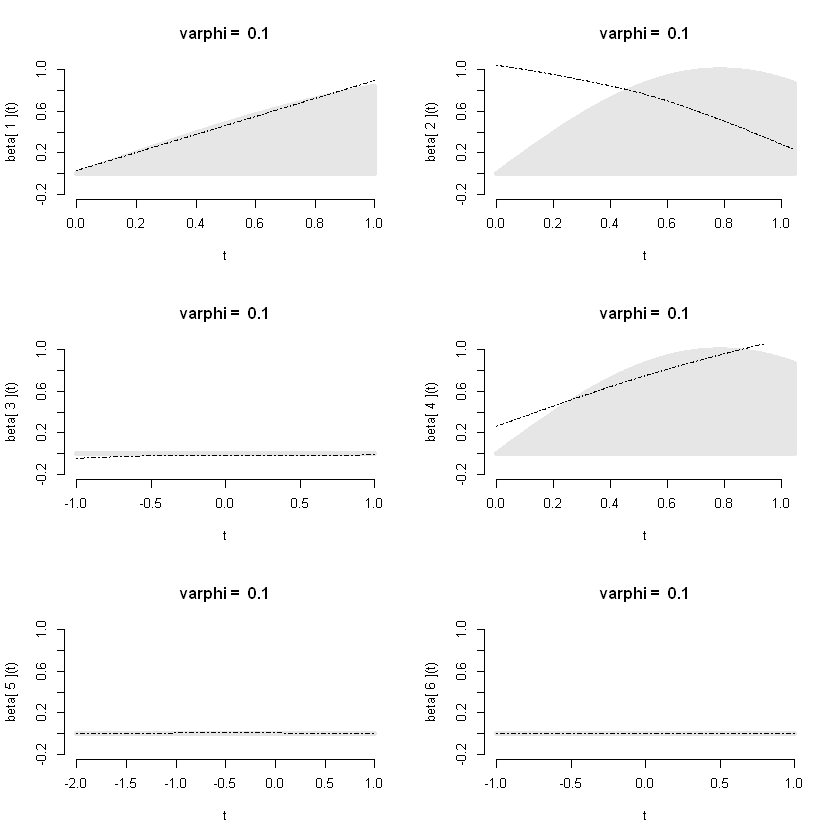

In [ ]:
par(mfrow=c(3,2))  # Arrange the plots in a 3x2 grid
for (j in 1:predictors) {
  plot(tps[[j]], beta_funcs[[j]](tps[[j]]), type="h",col=grey(0.9),ylim=c(-0.2,1),lwd=5, xlab="t", ylab=paste("beta[", j, "](t)"), bty="n")
  lines(tps[[j]], grpl[[5]]$Coef[[j]][,4],lty=4)
  title(paste("varphi = ", phi[5]))
}


In [ ]:
# fit using functional smooth group lasso
lambda <- 10^seq(15,-90,by=-1)
phi <- 10^-1

grpl <- list()
for (i in 1:length(phi)) {
  grpl[[i]] <- grplFlinear(Y = Y, X = fobs, Tps = tps, lambda = lambda, phi = phi[i], dfs = 45)
}



Setting update.every = length(lambda) + 1
Lambda: 1e+15  nr.var: 1 
Lambda: 1e+14  nr.var: 1 
Lambda: 1e+13  nr.var: 1 
Lambda: 1e+12  nr.var: 1 
Lambda: 1e+11  nr.var: 1 
Lambda: 1e+10  nr.var: 1 
Lambda: 1e+09  nr.var: 1 
Lambda: 1e+08  nr.var: 1 
Lambda: 1e+07  nr.var: 1 
Lambda: 1e+06  nr.var: 1 
Lambda: 1e+05  nr.var: 1 
Lambda: 10000  nr.var: 1 
Lambda: 1000  nr.var: 1 
Lambda: 100  nr.var: 136 
Lambda: 10  nr.var: 136 
Lambda: 1  nr.var: 181 
Lambda: 0.1  nr.var: 271 
Lambda: 0.01  nr.var: 271 
Lambda: 0.001  nr.var: 271 
Lambda: 1e-04  nr.var: 271 
Lambda: 1e-05  nr.var: 271 
Lambda: 1e-06  nr.var: 271 
Lambda: 1e-07  nr.var: 271 
Lambda: 1e-08  nr.var: 271 
Lambda: 1e-09  nr.var: 271 
Lambda: 1e-10  nr.var: 271 
Lambda: 1e-11  nr.var: 271 
Lambda: 1e-12  nr.var: 271 
Lambda: 1e-13  nr.var: 271 
Lambda: 1e-14  nr.var: 271 
Lambda: 1e-15  nr.var: 271 
Lambda: 1e-16  nr.var: 271 
Lambda: 1e-17  nr.var: 271 
Lambda: 1e-18  nr.var: 271 
Lambda: 1e-19  nr.var: 271 
Lambda: 1e-20  nr

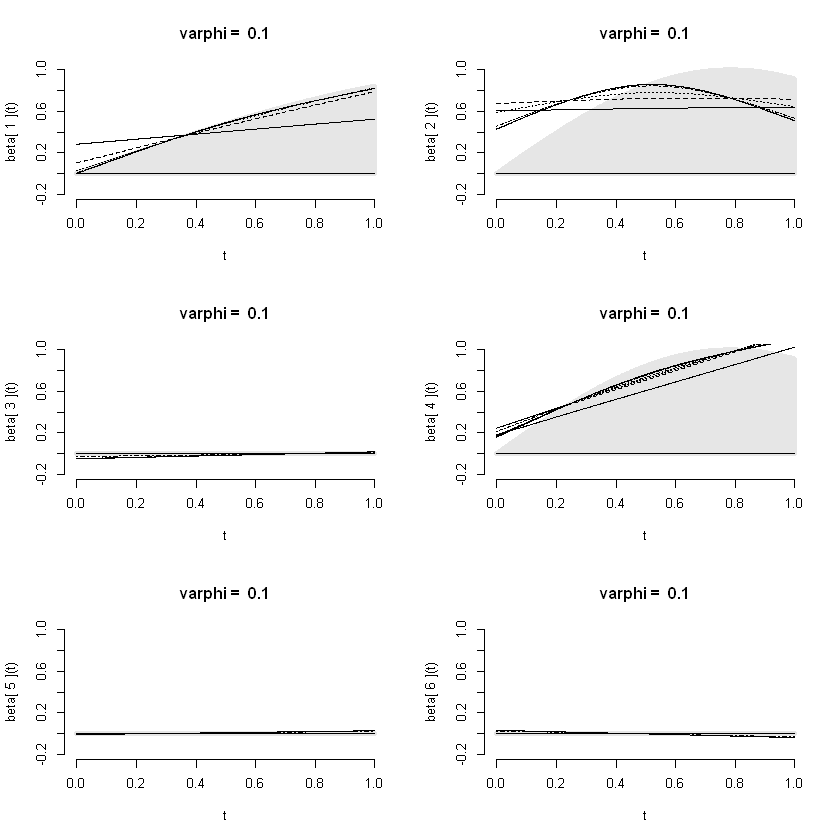

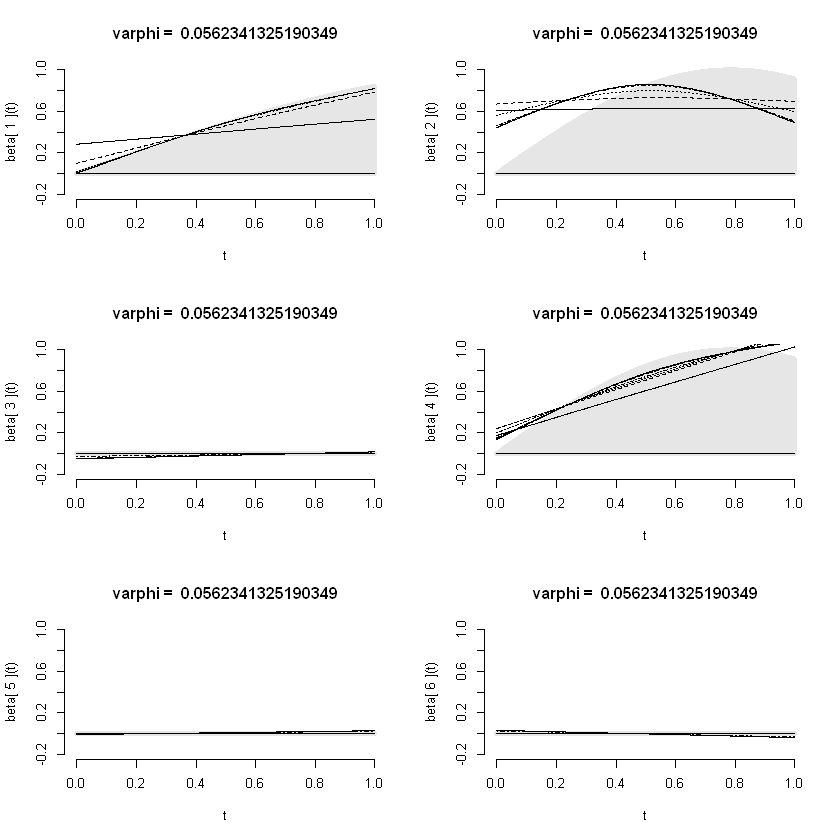

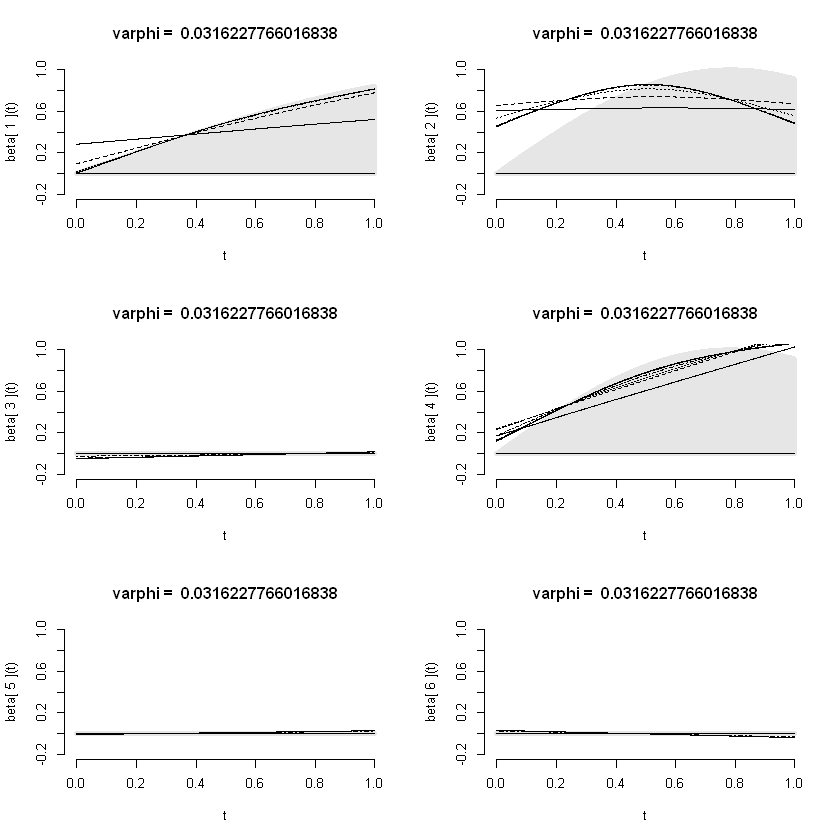

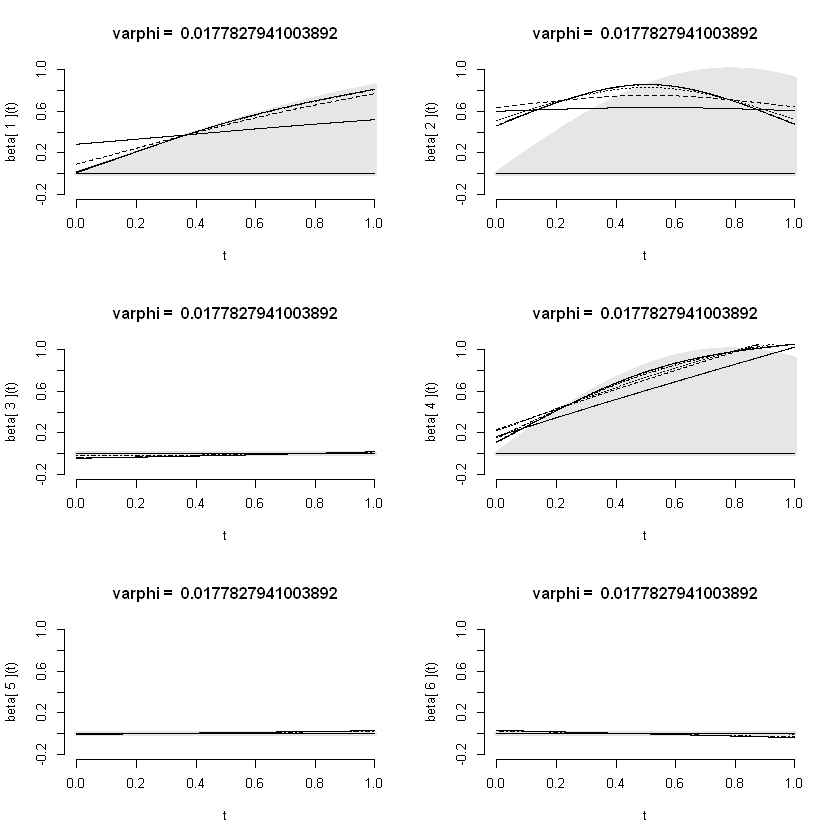

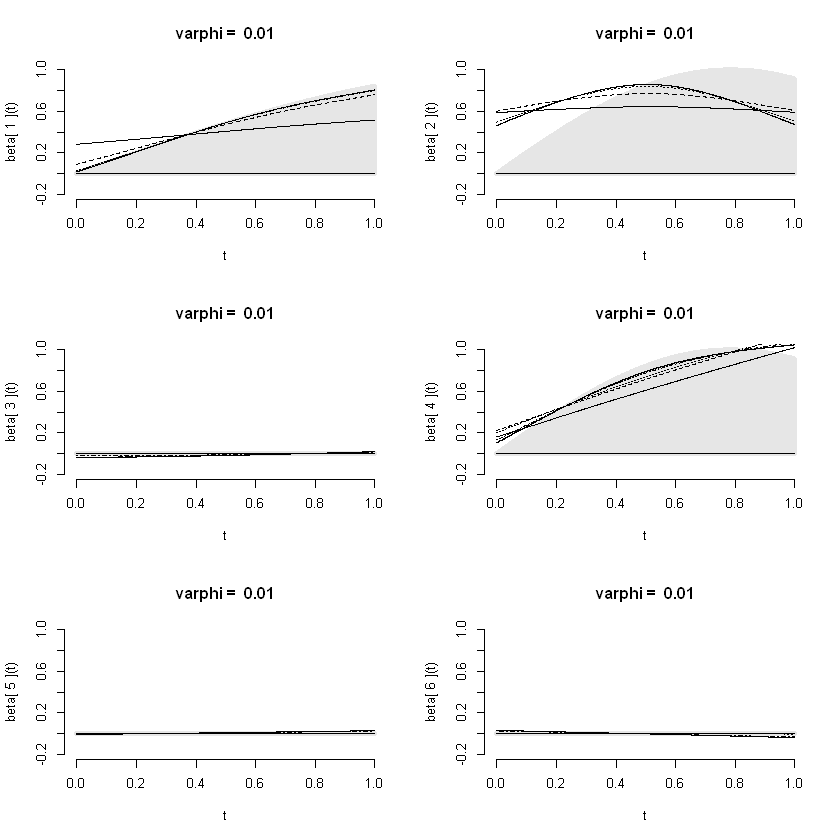

In [ ]:
for (i in 1:length(phi)) {
  par(mfrow=c(3,2))  # Arrange the plots in a 3x2 grid
  for (j in 1:predictors) {
    plot(tps[[j]], beta_funcs[[j]](tps[[j]]), type="h",col=grey(0.9),ylim=c(-0.2,1),lwd=5, xlab="t", ylab=paste("beta[", j, "](t)"), bty="n")
    for(wl in 1:length(lambda)) {
      lines(tps[[j]], grpl[[i]]$Coef[[j]][,wl],lty=wl)
    }
    title(paste("varphi = ", phi[i]))
  }
}

In [ ]:
for (i in 1:length(phi)) {
  par(mfrow=c(3,2))  # Arrange the plots in a 3x2 grid
  for (j in 1:predictors) {
    plot(tps[[j]], beta_funcs[[j]](tps[[j]]), type="h",col=grey(0.9),ylim=c(-0.2,1),lwd=5, xlab="t", ylab=paste("beta[", j, "](t)"), bty="n")
    lines(tps[[j]], grpl[[i]]$Coef[[j]][,60],lty=60)
    title(paste("varphi = ", phi[i]))
  }
}

ERROR: Error in eval(expr, envir, enclos): oggetto 'phi' non trovato
